In [1]:
import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [2]:
import gym
       
env = gym.make("Acrobot-v1")
env.reset()
observation_shape = env.observation_space.shape
n_actions = env.action_space.n
print("Observation Space", env.observation_space)
print("Action Space", env.action_space)



Observation Space Box([ -1.        -1.        -1.        -1.       -12.566371 -28.274334], [ 1.        1.        1.        1.       12.566371 28.274334], (6,), float32)
Action Space Discrete(3)


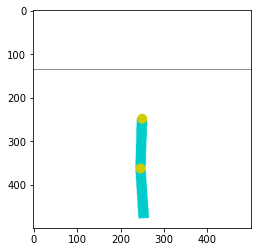

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(env.render('rgb_array'))

### Step 1: Defining a network

With all it's complexity, at it's core TRPO is yet another policy gradient method. 

This essentially means we're actually training a stochastic policy $ \pi_\theta(a|s) $. 

And yes, it's gonna be a neural network. So let's start by defining one.

In [4]:
class TRPOAgent(nn.Module):
    def __init__(self, state_shape, n_actions, hidden_size = 32):
        '''
        Here you should define your model
        You should have LOG-PROBABILITIES as output because you will need it to compute loss
        We recommend that you start simple: 
        use 1-2 hidden layers with 100-500 units and relu for the first try
        '''
        nn.Module.__init__(self)
        
        #<your network here>
        self.fc1 = nn.Linear(state_shape[0], 128)
        self.fc2 = nn.Linear(128, hidden_size)
        self.fc3 = nn.Linear(hidden_size, n_actions)
        #self.model = None

    def forward(self, states):
        """
        takes agent's observation (Variable), returns log-probabilities (Variable)
        :param state_t: a batch of states, shape = [batch_size, state_shape]
        """
        
        # Use your network to compute log_probs for given state
        x = F.relu(self.fc1(states))
        x = F.relu(self.fc2(x))
        x = F.log_softmax(self.fc3(x))
        log_probs = x
        #log_probs = self.model(states)
        return log_probs
    
    def get_log_probs(self, states):
        '''
        Log-probs for training
        '''
        
        return self.forward(states)
    
    def get_probs(self, states):
        '''
        Probs for interaction
        '''
        
        return torch.exp(self.forward(states))
    
    def act(self, obs, sample=True):
        '''
        Samples action from policy distribution (sample = True) or takes most likely action (sample = False)
        :param: obs - single observation vector
        :param sample: if True, samples from \pi, otherwise takes most likely action
        :returns: action (single integer) and probabilities for all actions
        '''

        probs = self.get_probs(Variable(torch.FloatTensor([obs]))).data.numpy()

        if sample:
            action = int(np.random.choice(n_actions,p=probs[0]))
        else:
            action = int(np.argmax(probs))

        return action, probs[0]

agent = TRPOAgent(observation_shape, n_actions)

In [5]:
# Check if log-probabilities satisfies all the requirements
log_probs = agent.get_log_probs(Variable(torch.FloatTensor([env.reset()])))
assert isinstance(log_probs, Variable) and log_probs.requires_grad, "qvalues must be a torch variable with grad"
assert len(log_probs.shape) == 2 and log_probs.shape[0] == 1 and log_probs.shape[1] == n_actions
sums = torch.sum(torch.exp(log_probs), dim=1)
assert (0.999<sums).all() and (1.001>sums).all()

# Demo use
print ("sampled:", [agent.act(env.reset()) for _ in range(5)])
print ("greedy:", [agent.act(env.reset(),sample=False) for _ in range(5)])

sampled: [(0, array([0.29997447, 0.34539706, 0.35462847], dtype=float32)), (1, array([0.3005915 , 0.34484622, 0.35456225], dtype=float32)), (0, array([0.3018576 , 0.34221107, 0.35593143], dtype=float32)), (0, array([0.30023244, 0.34541604, 0.3543515 ], dtype=float32)), (2, array([0.30013195, 0.3448025 , 0.35506552], dtype=float32))]
greedy: [(2, array([0.30046913, 0.34327874, 0.35625213], dtype=float32)), (2, array([0.30024752, 0.34519276, 0.35455972], dtype=float32)), (2, array([0.30109003, 0.34426674, 0.35464326], dtype=float32)), (2, array([0.30148703, 0.3446222 , 0.3538907 ], dtype=float32)), (2, array([0.30106112, 0.3442391 , 0.35469973], dtype=float32))]


/var/folders/x9/xgj8n5xd2bb0cv55w7c72bn40000gn/T/ipykernel_34251/1516872198.py:26: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(self.fc3(x))


#### Flat parameters operations

We are going to use it

In [6]:
def get_flat_params_from(model):
    params = []
    for param in model.parameters():
        params.append(param.data.view(-1))

    flat_params = torch.cat(params)
    return flat_params


def set_flat_params_to(model, flat_params):
    prev_ind = 0
    for param in model.parameters():
        flat_size = int(np.prod(list(param.size())))
        param.data.copy_(
            flat_params[prev_ind:prev_ind + flat_size].view(param.size()))
        prev_ind += flat_size

Compute cummulative reward just like you did in vanilla REINFORCE

In [7]:
import scipy.signal
def get_cummulative_returns(r, gamma=1):
    """
    Computes cummulative discounted rewards given immediate rewards
    G_i = r_i + gamma*r_{i+1} + gamma^2*r_{i+2} + ...
    Also known as R(s,a).
    """
    r = np.array(r)
    assert r.ndim >= 1
    return scipy.signal.lfilter([1], [1, -gamma], r[::-1], axis=0)[::-1]

In [8]:
#simple demo on rewards [0,0,1,0,0,1]
get_cummulative_returns([0,0,1,0,0,1], gamma=0.9)

array([1.40049, 1.5561 , 1.729  , 0.81   , 0.9    , 1.     ])

In [9]:
def rollout(env, agent, max_pathlength=2500, n_timesteps=50000):
    """
    Generate rollouts for training.
    :param: env - environment in which we will make actions to generate rollouts.
    :param: act - the function that can return policy and action given observation.
    :param: max_pathlength - maximum size of one path that we generate.
    :param: n_timesteps - total sum of sizes of all pathes we generate.
    """
    paths = []

    total_timesteps = 0
    while total_timesteps < n_timesteps:
        obervations, actions, rewards, action_probs = [], [], [], []
        obervation = env.reset()
        for _ in range(max_pathlength):
            action, policy = agent.act(obervation)
            obervations.append(obervation)
            actions.append(action)
            action_probs.append(policy)
            obervation, reward, done, _ = env.step(action)
            rewards.append(reward)
            total_timesteps += 1
            if done or total_timesteps==n_timesteps:
                path = {"observations": np.array(obervations),
                        "policy": np.array(action_probs),
                        "actions": np.array(actions),
                        "rewards": np.array(rewards),
                        "cumulative_returns":get_cummulative_returns(rewards),
                       }
                paths.append(path)
                break
    return paths

In [10]:
paths = rollout(env,agent,max_pathlength=5,n_timesteps=100)
print (paths[-1])
assert (paths[0]['policy'].shape==(5, n_actions))
assert (paths[0]['cumulative_returns'].shape==(5,))
assert (paths[0]['rewards'].shape==(5,))
assert (paths[0]['observations'].shape==(5,)+observation_shape)
assert (paths[0]['actions'].shape==(5,))
print ('It\'s ok')

{'observations': array([[ 0.9990155 ,  0.04436263,  0.99880236,  0.04892679,  0.04419691,
        -0.09611846],
       [ 0.9981093 ,  0.06146457,  0.99998957, -0.00456277,  0.12180795,
        -0.42684656],
       [ 0.99595314,  0.08987395,  0.9934774 , -0.11402917,  0.15363374,
        -0.64648503],
       [ 0.9957371 ,  0.09223689,  0.9831381 , -0.18286487, -0.1317553 ,
        -0.03885483],
       [ 0.99922574,  0.03934298,  0.99145436, -0.13045381, -0.38587114,
         0.5523198 ]], dtype=float32), 'policy': array([[0.3022726 , 0.34406286, 0.35366452],
       [0.3059908 , 0.3408064 , 0.3532028 ],
       [0.3071583 , 0.33912918, 0.3537125 ],
       [0.2993085 , 0.3443393 , 0.3563522 ],
       [0.2928005 , 0.35279307, 0.35440642]], dtype=float32), 'actions': array([0, 0, 2, 2, 1]), 'rewards': array([-1., -1., -1., -1., -1.]), 'cumulative_returns': array([-5., -4., -3., -2., -1.])}
It's ok


/var/folders/x9/xgj8n5xd2bb0cv55w7c72bn40000gn/T/ipykernel_34251/1516872198.py:26: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(self.fc3(x))


### Step 3: Auxiliary functions

Now let's define the loss functions and something else for actual TRPO training.

The surrogate reward should be
$$J_{surr}= {1 \over N} \sum\limits_{i=0}^N \frac{\pi_{\theta}(s_i, a_i)}{\pi_{\theta_{old}}(s_i, a_i)}A_{\theta_{old}(s_i, a_i)}$$

For simplicity, let's use cummulative returns instead of advantage for now:
$$J'_{surr}= {1 \over N} \sum\limits_{i=0}^N \frac{\pi_{\theta}(s_i, a_i)}{\pi_{\theta_{old}}(s_i, a_i)}G_{\theta_{old}(s_i, a_i)}$$

Or alternatively, minimize the surrogate loss:
$$ L_{surr} = - J'_{surr} $$  

In [11]:
def get_loss(agent, observations, actions, cummulative_returns, old_probs):
    """
    Computes TRPO objective
    :param: observations - batch of observations
    :param: actions - batch of actions
    :param: cummulative_returns - batch of cummulative returns
    :param: old_probs - batch of probabilities computed by old network
    :returns: scalar value of the objective function
    """
    batch_size = observations.shape[0]
    log_probs_all = agent.get_log_probs(observations)
    probs_all = torch.exp(log_probs_all)
    
    probs_for_actions = probs_all[torch.arange(0, batch_size, out=torch.LongTensor()), actions]
    old_probs_for_actions = old_probs[torch.arange(0, batch_size, out=torch.LongTensor()), actions]
    
    # Compute surrogate loss, aka importance-sampled policy gradient
    Loss = torch.mean(((probs_for_actions/ old_probs_for_actions) * cummulative_returns),dim = 0, keepdim = True) #<compute surrogate loss>
    Loss = -Loss
    
    assert Loss.shape == torch.Size([1])
    return Loss

We can ascend these gradients as long as our $pi_\theta(a|s)$ satisfies the constraint
$$E_{s,\pi_{\Theta_{t}}}\Big[KL(\pi(\Theta_{t}, s) \:||\:\pi(\Theta_{t+1}, s))\Big]< \alpha$$


where

$$KL(p||q) = E _p log({p \over q})$$

In [12]:
def get_kl(agent, observations, actions, cummulative_returns, old_probs):
    """
    Computes KL-divergence between network policy and old policy
    :param: observations - batch of observations
    :param: actions - batch of actions
    :param: cummulative_returns - batch of cummulative returns (we don't need it actually)
    :param: old_probs - batch of probabilities computed by old network
    :returns: scalar value of the KL-divergence
    """
    #print(observations.shape)
    batch_size = observations.shape[0]
    log_probs_all = agent.get_log_probs(observations)
    probs_all = torch.exp(log_probs_all)
    
    # Compute Kullback-Leibler divergence (see formula above)
    # Note: you need to sum KL and entropy over all actions, not just the ones agent took
    old_log_probs = torch.log(old_probs+1e-10)
    
    #print(log_probs_all.shape)
    #print(old_log_probs.shape)
    
    kl =  torch.mean(torch.sum(old_probs * (old_log_probs - log_probs_all), 1), dim = 0, keepdim = True) #<compute kullback-leibler>
    
    #print(kl.shape)
    
    assert kl.shape == torch.Size([1])
    assert (kl>-0.0001).all() and (kl<10000).all()
    return kl

In [13]:
def get_entropy(agent, observations):
    """
    Computes entropy of the network policy 
    :param: observations - batch of observations
    :returns: scalar value of the entropy
    """
    
    observations = Variable(torch.FloatTensor(observations))

    batch_size = observations.shape[0]
    log_probs_all = agent.get_log_probs(observations)
    probs_all = torch.exp(log_probs_all)
    
    #print(probs_all.shape)
    
    entropy = torch.sum(-probs_all * log_probs_all) / batch_size
    entropy = entropy.unsqueeze(0)
    #print(entropy.shape)
    
    assert entropy.shape == torch.Size([1])
    return entropy

**Linear search**

TRPO in its core involves ascending surrogate policy gradient constrained by KL divergence. 

In order to enforce this constraint, we're gonna use linesearch. You can find out more about it [here](https://en.wikipedia.org/wiki/Linear_search)

In [14]:
def linesearch(f, x, fullstep, max_kl):
    """
    Linesearch finds the best parameters of neural networks in the direction of fullstep contrainted by KL divergence.
    :param: f - function that returns loss, kl and arbitrary third component.
    :param: x - old parameters of neural network.
    :param: fullstep - direction in which we make search.
    :param: max_kl - constraint of KL divergence.
    :returns:
    """
    max_backtracks = 10
    loss, _, = f(x)
    for stepfrac in .5**np.arange(max_backtracks):
        xnew = x + stepfrac * fullstep
        new_loss, kl = f(xnew)
        actual_improve = new_loss - loss
        if kl.data.numpy()<=max_kl and actual_improve.data.numpy() < 0:
            x = xnew
            loss = new_loss
    return x

**Conjugate gradients**

Since TRPO includes contrainted optimization, we will need to solve Ax=b using conjugate gradients.

In general, CG is an algorithm that solves Ax=b where A is positive-defined. A is Hessian matrix so A is positive-defined. You can find out more about them [here](https://en.wikipedia.org/wiki/Conjugate_gradient_method)

In [15]:
from numpy.linalg import inv
def conjugate_gradient(f_Ax, b, cg_iters=10, residual_tol=1e-10):
    """
    This method solves system of equation Ax=b using iterative method called conjugate gradients
    :f_Ax: function that returns Ax
    :b: targets for Ax
    :cg_iters: how many iterations this method should do
    :residual_tol: epsilon for stability
    """
    p = b.clone()
    r = b.clone()
    x = torch.zeros(b.size())
    rdotr = torch.sum(r*r)
    for i in range(cg_iters):
        z = f_Ax(p)
        v = rdotr / (torch.sum(p*z) + 1e-8)
        x += v * p
        r -= v * z
        newrdotr = torch.sum(r*r)
        mu = newrdotr / (rdotr + 1e-8)
        p = r + mu * p
        rdotr = newrdotr
        if rdotr < residual_tol:
            break
    return x

In [16]:
#This code validates conjugate gradients
A = np.random.rand(8, 8)
A = np.matmul(np.transpose(A), A)

def f_Ax(x):
    return torch.matmul(torch.FloatTensor(A), x.view((-1, 1))).view(-1)

b = np.random.rand(8)

w = np.matmul(np.matmul(inv(np.matmul(np.transpose(A), A)), np.transpose(A)), b.reshape((-1, 1))).reshape(-1)
print (w)
print (conjugate_gradient(f_Ax, torch.FloatTensor(b)).numpy())

[ 0.21992212 -4.36614886 -4.72050511  0.23221551 -5.03578392 -5.60225922
 12.9447162   6.47305433]
[ 0.21988131 -4.3661146  -4.720257    0.23229481 -5.035783   -5.6022105
 12.944579    6.472925  ]


### Step 4: training
In this section we construct the whole update step function.

In [17]:
def update_step(agent, observations, actions, cummulative_returns, old_probs, max_kl):
    """
    This function does the TRPO update step
    :param: observations - batch of observations
    :param: actions - batch of actions
    :param: cummulative_returns - batch of cummulative returns
    :param: old_probs - batch of probabilities computed by old network
    :param: max_kl - controls how big KL divergence may be between old and new policy every step.
    :returns: KL between new and old policies and the value of the loss function.
    """
    
    # Here we prepare the information
    observations = Variable(torch.FloatTensor(observations))
    actions = torch.LongTensor(actions)
    cummulative_returns = Variable(torch.FloatTensor(cummulative_returns))
    old_probs = Variable(torch.FloatTensor(old_probs))
    
    # Here we compute gradient of the loss function
    loss = get_loss(agent, observations, actions, cummulative_returns, old_probs)
    grads = torch.autograd.grad(loss, agent.parameters())
    loss_grad = torch.cat([grad.view(-1) for grad in grads]).data

    def Fvp(v):
        # Here we compute Fx to do solve Fx = g using conjugate gradients
        # We actually do here a couple of tricks to compute it efficiently
        
        kl = get_kl(agent, observations, actions, cummulative_returns, old_probs)

        grads = torch.autograd.grad(kl, agent.parameters(), create_graph=True)
        flat_grad_kl = torch.cat([grad.view(-1) for grad in grads])

        kl_v = (flat_grad_kl * Variable(v)).sum()
        grads = torch.autograd.grad(kl_v, agent.parameters())
        flat_grad_grad_kl = torch.cat([grad.contiguous().view(-1) for grad in grads]).data

        return flat_grad_grad_kl + v * 0.1
    
    # Here we solveolve Fx = g system using conjugate gradients
    stepdir = conjugate_gradient(Fvp, -loss_grad, 10)

    # Here we compute the initial vector to do linear search
    shs = 0.5 * (stepdir * Fvp(stepdir)).sum(0, keepdim=True)

    lm = torch.sqrt(shs / max_kl)
    fullstep = stepdir / lm[0]

    neggdotstepdir = (-loss_grad * stepdir).sum(0, keepdim=True)
    
    # Here we get the start point
    prev_params = get_flat_params_from(agent)
    
    def get_loss_kl(params):
        # Helper for linear search
        set_flat_params_to(agent, params)
        return [get_loss(agent, observations, actions, cummulative_returns, old_probs),
                get_kl(agent, observations, actions, cummulative_returns, old_probs)]
    
    # Here we find our new parameters
    new_params = linesearch(get_loss_kl, prev_params, fullstep, max_kl)
    
    # And we set it to our network
    set_flat_params_to(agent, new_params)

    return get_loss_kl(new_params)

##### Step 5: Main TRPO loop

Here we will train our network!

In [19]:
import time
from itertools import count
from collections import OrderedDict

max_kl=0.01           #this is hyperparameter of TRPO. It controls how big KL divergence may be between old and new policy every step.
numeptotal = 0        #this is number of episodes that we played.

start_time = time.time()

for i in count(1):

    print ("\n********** Iteration %i ************" % i)

    # Generating paths.
    print("Rollout")
    paths = rollout(env, agent)
    print ("Made rollout")
    
    # Updating policy.
    observations = np.concatenate([path["observations"] for path in paths])
    actions = np.concatenate([path["actions"] for path in paths])
    returns = np.concatenate([path["cumulative_returns"] for path in paths])
    old_probs = np.concatenate([path["policy"] for path in paths])
    
    loss, kl = update_step(agent, observations, actions, returns, old_probs, max_kl)

    #Report current progress
    episode_rewards = np.array([path["rewards"].sum() for path in paths])

    stats = OrderedDict()
    numeptotal += len(episode_rewards)
    stats["Total number of episodes"] = numeptotal
    stats["Average sum of rewards per episode"] = episode_rewards.mean()
    stats["Std of rewards per episode"] = episode_rewards.std()
    stats["Time elapsed"] = "%.2f mins" % ((time.time() - start_time)/60.)
    stats["KL between old and new distribution"] = kl.data.numpy()
    stats["Entropy"] = get_entropy(agent, observations).data.numpy()
    stats["Surrogate loss"] = loss.data.numpy()
    for k, v in stats.items():
        print(k + ": " + " " * (40 - len(k)) + str(v))
    i += 1


********** Iteration 1 ************
Rollout


/var/folders/x9/xgj8n5xd2bb0cv55w7c72bn40000gn/T/ipykernel_34251/1516872198.py:26: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(self.fc3(x))


Made rollout
Total number of episodes:                 101
Average sum of rewards per episode:       -495.029702970297
Std of rewards per episode:               38.12627675396188
Time elapsed:                             0.13 mins
KL between old and new distribution:      [0.00999993]
Entropy:                                  [1.0821439]
Surrogate loss:                           [248.95103]

********** Iteration 2 ************
Rollout
Made rollout
Total number of episodes:                 226
Average sum of rewards per episode:       -399.28
Std of rewards per episode:               86.93074024762473
Time elapsed:                             0.25 mins
KL between old and new distribution:      [0.00997453]
Entropy:                                  [1.0604705]
Surrogate loss:                           [208.68262]

********** Iteration 3 ************
Rollout
Made rollout
Total number of episodes:                 403
Average sum of rewards per episode:       -281.50282485875704
Std of rewa

Made rollout
Total number of episodes:                 7805
Average sum of rewards per episode:       -92.81050656660413
Std of rewards per episode:               20.20299706386474
Time elapsed:                             2.46 mins
KL between old and new distribution:      [0.00998573]
Entropy:                                  [0.44615805]
Surrogate loss:                           [48.34249]

********** Iteration 21 ************
Rollout
Made rollout
Total number of episodes:                 8348
Average sum of rewards per episode:       -91.0828729281768
Std of rewards per episode:               19.316271956056987
Time elapsed:                             2.58 mins
KL between old and new distribution:      [0.00998852]
Entropy:                                  [0.4082182]
Surrogate loss:                           [47.387226]

********** Iteration 22 ************
Rollout
Made rollout
Total number of episodes:                 8893
Average sum of rewards per episode:       -90.7467889908

Made rollout
Total number of episodes:                 17894
Average sum of rewards per episode:       -90.40950639853747
Std of rewards per episode:               19.144990445841138
Time elapsed:                             4.69 mins
KL between old and new distribution:      [0.00997579]
Entropy:                                  [0.32590413]
Surrogate loss:                           [47.057434]

********** Iteration 40 ************
Rollout
Made rollout
Total number of episodes:                 18442
Average sum of rewards per episode:       -90.24270072992701
Std of rewards per episode:               28.500823422696953
Time elapsed:                             4.80 mins
KL between old and new distribution:      [0.009984]
Entropy:                                  [0.30423582]
Surrogate loss:                           [49.33855]

********** Iteration 41 ************
Rollout
Made rollout
Total number of episodes:                 19009
Average sum of rewards per episode:       -87.185185

Made rollout
Total number of episodes:                 28773
Average sum of rewards per episode:       -83.46283783783784
Std of rewards per episode:               24.444199500985377
Time elapsed:                             6.93 mins
KL between old and new distribution:      [0.00999688]
Entropy:                                  [0.12710975]
Surrogate loss:                           [45.13797]

********** Iteration 59 ************
Rollout
Made rollout
Total number of episodes:                 29357
Average sum of rewards per episode:       -84.6181506849315
Std of rewards per episode:               21.836481649446394
Time elapsed:                             7.05 mins
KL between old and new distribution:      [0.00998602]
Entropy:                                  [0.12903516]
Surrogate loss:                           [44.93746]

********** Iteration 60 ************
Rollout
Made rollout
Total number of episodes:                 29949
Average sum of rewards per episode:       -83.461148

Made rollout
Total number of episodes:                 40058
Average sum of rewards per episode:       -83.74915254237288
Std of rewards per episode:               28.37870037325592
Time elapsed:                             9.16 mins
KL between old and new distribution:      [0.00998345]
Entropy:                                  [0.08404916]
Surrogate loss:                           [46.503464]

********** Iteration 78 ************
Rollout
Made rollout
Total number of episodes:                 40660
Average sum of rewards per episode:       -82.05813953488372
Std of rewards per episode:               19.17418691143771
Time elapsed:                             9.27 mins
KL between old and new distribution:      [0.00999365]
Entropy:                                  [0.0717639]
Surrogate loss:                           [43.160053]

********** Iteration 79 ************
Rollout
Made rollout
Total number of episodes:                 41260
Average sum of rewards per episode:       -82.335
St

Made rollout
Total number of episodes:                 51445
Average sum of rewards per episode:       -85.65684575389947
Std of rewards per episode:               23.24923566918946
Time elapsed:                             11.42 mins
KL between old and new distribution:      [0.00999899]
Entropy:                                  [0.12526284]
Surrogate loss:                           [45.79]

********** Iteration 97 ************
Rollout
Made rollout
Total number of episodes:                 52009
Average sum of rewards per episode:       -87.65425531914893
Std of rewards per episode:               21.23524017181511
Time elapsed:                             11.54 mins
KL between old and new distribution:      [0.00998547]
Entropy:                                  [0.12382884]
Surrogate loss:                           [46.2013]

********** Iteration 98 ************
Rollout
Made rollout
Total number of episodes:                 52608
Average sum of rewards per episode:       -82.474123539

Made rollout
Total number of episodes:                 62955
Average sum of rewards per episode:       -82.47412353923205
Std of rewards per episode:               18.325445463721653
Time elapsed:                             13.64 mins
KL between old and new distribution:      [0.00998436]
Entropy:                                  [0.08756898]
Surrogate loss:                           [43.085735]

********** Iteration 116 ************
Rollout
Made rollout
Total number of episodes:                 63561
Average sum of rewards per episode:       -81.51155115511551
Std of rewards per episode:               24.26637853691581
Time elapsed:                             13.75 mins
KL between old and new distribution:      [0.00997771]
Entropy:                                  [0.09014142]
Surrogate loss:                           [44.15797]

********** Iteration 117 ************
Rollout
Made rollout
Total number of episodes:                 64183
Average sum of rewards per episode:       -79.3

Made rollout
Total number of episodes:                 74707
Average sum of rewards per episode:       -78.49284578696343
Std of rewards per episode:               17.36420022955703
Time elapsed:                             15.86 mins
KL between old and new distribution:      [0.00998589]
Entropy:                                  [0.1056475]
Surrogate loss:                           [40.994137]

********** Iteration 135 ************
Rollout
Made rollout
Total number of episodes:                 75329
Average sum of rewards per episode:       -79.38745980707395
Std of rewards per episode:               19.892945888424048
Time elapsed:                             15.97 mins
KL between old and new distribution:      [0.00999392]
Entropy:                                  [0.09246754]
Surrogate loss:                           [42.009716]

********** Iteration 136 ************
Rollout
Made rollout
Total number of episodes:                 75966
Average sum of rewards per episode:       -77.4

Made rollout
Total number of episodes:                 86658
Average sum of rewards per episode:       -77.86593059936908
Std of rewards per episode:               17.346242245311764
Time elapsed:                             18.08 mins
KL between old and new distribution:      [0.00997422]
Entropy:                                  [0.06241414]
Surrogate loss:                           [40.693325]

********** Iteration 154 ************
Rollout
Made rollout
Total number of episodes:                 87283
Average sum of rewards per episode:       -79.0016
Std of rewards per episode:               20.53262763116304
Time elapsed:                             18.20 mins
KL between old and new distribution:      [0.0099943]
Entropy:                                  [0.07449727]
Surrogate loss:                           [41.94734]

********** Iteration 155 ************
Rollout
Made rollout
Total number of episodes:                 87917
Average sum of rewards per episode:       -77.865930599369

Made rollout
Total number of episodes:                 98997
Average sum of rewards per episode:       -75.45412844036697
Std of rewards per episode:               14.743584301756945
Time elapsed:                             20.36 mins
KL between old and new distribution:      [0.00998812]
Entropy:                                  [0.05564013]
Surrogate loss:                           [39.059475]

********** Iteration 173 ************
Rollout
Made rollout
Total number of episodes:                 99664
Average sum of rewards per episode:       -73.9640179910045
Std of rewards per episode:               14.702198044306476
Time elapsed:                             20.49 mins
KL between old and new distribution:      [0.00998634]
Entropy:                                  [0.0569233]
Surrogate loss:                           [38.316505]

********** Iteration 174 ************
Rollout
Made rollout
Total number of episodes:                 100317
Average sum of rewards per episode:       -75.

Made rollout
Total number of episodes:                 111500
Average sum of rewards per episode:       -76.76205287713842
Std of rewards per episode:               16.547711032654068
Time elapsed:                             22.63 mins
KL between old and new distribution:      [0.00999501]
Entropy:                                  [0.06310903]
Surrogate loss:                           [39.98038]

********** Iteration 192 ************
Rollout
Made rollout
Total number of episodes:                 112136
Average sum of rewards per episode:       -77.61792452830188
Std of rewards per episode:               16.931054961446186
Time elapsed:                             22.74 mins
KL between old and new distribution:      [0.00999746]
Entropy:                                  [0.06335494]
Surrogate loss:                           [40.47893]

********** Iteration 193 ************
Rollout
Made rollout
Total number of episodes:                 112777
Average sum of rewards per episode:       -7

Made rollout
Total number of episodes:                 123994
Average sum of rewards per episode:       -73.73991031390135
Std of rewards per episode:               18.169717427139336
Time elapsed:                             169.43 mins
KL between old and new distribution:      [0.00998447]
Entropy:                                  [0.05607745]
Surrogate loss:                           [38.879833]

********** Iteration 211 ************
Rollout
Made rollout
Total number of episodes:                 124686
Average sum of rewards per episode:       -71.25578034682081
Std of rewards per episode:               13.724146839493656
Time elapsed:                             169.55 mins
KL between old and new distribution:      [0.00997378]
Entropy:                                  [0.05839751]
Surrogate loss:                           [36.805473]

********** Iteration 212 ************
Rollout
Made rollout
Total number of episodes:                 125351
Average sum of rewards per episode:     

Made rollout
Total number of episodes:                 136786
Average sum of rewards per episode:       -71.9941605839416
Std of rewards per episode:               15.689411401795695
Time elapsed:                             473.32 mins
KL between old and new distribution:      [0.00997829]
Entropy:                                  [0.05304595]
Surrogate loss:                           [37.495087]

********** Iteration 230 ************
Rollout
Made rollout
Total number of episodes:                 137455
Average sum of rewards per episode:       -73.73991031390135
Std of rewards per episode:               18.151197912043727
Time elapsed:                             492.20 mins
KL between old and new distribution:      [0.00998288]
Entropy:                                  [0.05447114]
Surrogate loss:                           [38.90162]

********** Iteration 231 ************
Rollout
Made rollout
Total number of episodes:                 138139
Average sum of rewards per episode:       

Made rollout
Total number of episodes:                 149761
Average sum of rewards per episode:       -70.84051724137932
Std of rewards per episode:               11.077787745829795
Time elapsed:                             693.31 mins
KL between old and new distribution:      [0.00999625]
Entropy:                                  [0.04533994]
Surrogate loss:                           [36.192375]

********** Iteration 249 ************
Rollout
Made rollout
Total number of episodes:                 150451
Average sum of rewards per episode:       -71.46521739130435
Std of rewards per episode:               11.560782357645913
Time elapsed:                             693.43 mins
KL between old and new distribution:      [0.00997748]
Entropy:                                  [0.04261634]
Surrogate loss:                           [36.55156]

********** Iteration 250 ************
Rollout
Made rollout
Total number of episodes:                 151126
Average sum of rewards per episode:      

KeyboardInterrupt: 

# Homework option I: better sampling (10+pts)

In this section, you're invited to implement a better rollout strategy called _vine_.

![img](https://s17.postimg.org/i90chxgvj/vine.png)

In most gym environments, you can actually backtrack by using states. You can find a wrapper that saves/loads states in [the mcts seminar](https://github.com/yandexdataschool/Practical_RL/blob/master/yet_another_week/seminar_MCTS.ipynb).

You can read more about in the [TRPO article](https://arxiv.org/abs/1502.05477) in section 5.2.

The goal here is to implement such rollout policy (we recommend using tree data structure like in the seminar above).
Then you can assign cummulative rewards similar to `get_cummulative_rewards`, but for a tree.

__bonus task__ - parallelize samples using multiple cores

# Homework option II (10+pts)

Let's use TRPO to train evil robots! (pick any of two)
* [MuJoCo robots](https://gym.openai.com/envs#mujoco)
* [Box2d robot](https://gym.openai.com/envs/BipedalWalker-v2)

The catch here is that those environments have continuous action spaces. 

Luckily, TRPO is a policy gradient method, so it's gonna work for any parametric $\pi_\theta(a|s)$. We recommend starting with gaussian policy:

$$\pi_\theta(a|s) = N(\mu_\theta(s),\sigma^2_\theta(s)) = {1 \over \sqrt { 2 \pi {\sigma^2}_\theta(s) } } e^{ (a - 
\mu_\theta(s))^2 \over 2 {\sigma^2}_\theta(s) } $$

In the $\sqrt { 2 \pi {\sigma^2}_\theta(s) }$ clause, $\pi$ means ~3.1415926, not agent's policy.

This essentially means that you will need two output layers:
* $\mu_\theta(s)$, a dense layer with linear activation
* ${\sigma^2}_\theta(s)$, a dense layer with activation tf.exp (to make it positive; like rho from bandits)

For multidimensional actions, you can use fully factorized gaussian (basically a vector of gaussians).

__bonus task__: compare performance of continuous action space method to action space discretization